### Graphing Module

In [1]:
# execute `brew install graphviz` in terminal to install directly to path

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Value() Class

In [133]:
import math

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._op = _op
        self._prev = set(_children)
        self._backward = lambda: None # by default, doesn't do anything
        self.label = label

    def _backward(self):
        self._backward = _backward

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # this line ensures that "other" is a Value object if it is a number
        
        out = Value( self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # make sure this is cummulative, else can't use the same variable
            other.grad += 1.0 * out.grad # make sure this is cummulative, else can't use the same variable
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value( self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad # make sure this is cummulative, else can't use the same variable
            other.grad += self.data * out.grad # make sure this is cummulative, else can't use the same variable
        out._backward = _backward
        
        return out

    def __rmul__(self,other):
        """
        This handles instances where you multiply 2 * x which gives an error, as it
        results in 2.__mul__(x) but 2 is not a Value object
        """
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting integer / float powers"
        out = Value( self.data ** other , (self, ), f"pwr of {other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        assert isinstance(other, (int, float)), "only supporting integer / float powers"
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other ** -1)

    def tanh(self):
        x = self.data
        t = (math.exp( 2*x ) - 1 ) / (math.exp( 2*x ) + 1)
        out = Value( t , (self, ), "tanh")
        
        def _backward():
            self.grad += ( 1 - t**2 ) * out.grad # make sure this is cummulative, else can't use the same variable
        out._backward = _backward
        
        return out

    def exp(self):
        out = Value( math.exp(self.data) , (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # topological sort algorithm
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        # building the topology of self
        build_topo(self)
        # initialise the gradient of the end
        self.grad = 1.0
        # calling _backward function for each node starting from the end
        for i in reversed(topo):
            i._backward()

### Testing Module of Value() and Graphing

In [5]:
x1 = Value(2.0, label ="x1")
x2 = Value(0.0, label ="x2")

w1 = Value(-3.0, label ="w1")
w2 = Value(1.0, label ="w2")

# bias of neuron
b = Value(6.88137, label = "b")

# x1w1 + x2w2 + b
x1w1 = x1*w1 ; x1w1.label = "x1w1"
x2w2 = x2*w2 ; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "x1w1 + x2w2 + b"

o = n.tanh(); o.label = "tanh( x1w1 + x2w2 + b )"

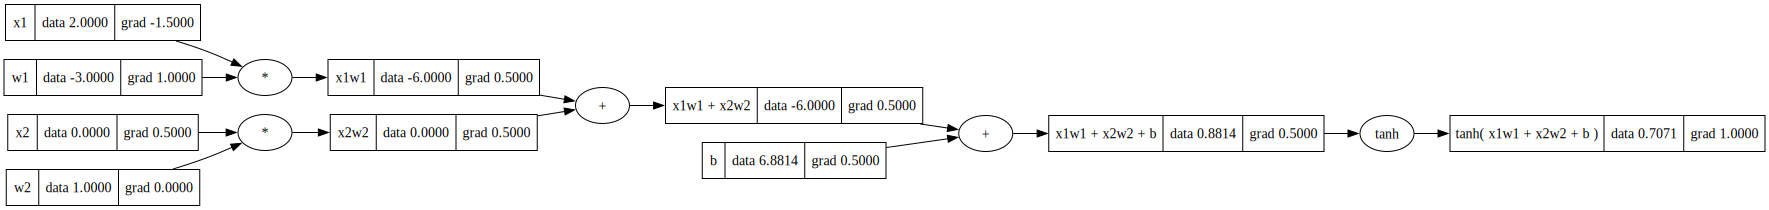

In [6]:
o.backward()
draw_dot(o)

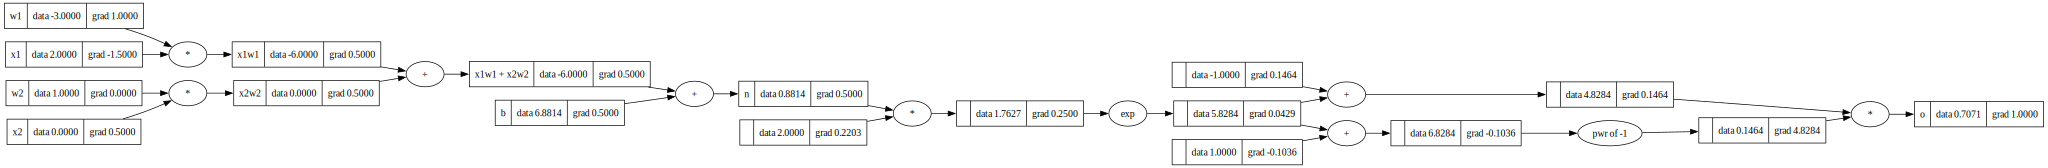

In [7]:
# Creating a new line to see if the backprop works for our exp

x1 = Value(2.0, label ="x1")
x2 = Value(0.0, label ="x2")

w1 = Value(-3.0, label ="w1")
w2 = Value(1.0, label ="w2")

# bias of neuron
b = Value(6.88137, label = "b")

# x1w1 + x2w2 + b
x1w1 = x1*w1 ; x1w1.label = "x1w1"
x2w2 = x2*w2 ; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"

# ---
e = (n * 2 ).exp()
o = (e - 1) / (e + 1)
# ---
o.label = "o"
o.backward()
draw_dot(o)

### Multi-Layer Perceptron

In [229]:
import random

class Neuron:

    def __init__(self, nin):
        """
        Initializes each neuron of equation `w1x1 + w2x2 + ... w(nin)x(nin) + bias`,
        where each weight and bias are Value() objects of random value between -1 and 1.
        :param nin: Number of input parameters.
        :type nin: int
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        """
        Call function that calculates the output value of the neuron
        :param x: 1 training data input
        :type x: list of floats of length nin
        :return: number between -1 and 1 after passing through activation function
        :rtype: float
        """
        activation = sum( (wi*xi for wi, xi in zip(self.w, x)) , self.b )
        out = activation.tanh()
        return out
    
    def parameters(self):
        """
        :return: Display a list of weights followed by the bias value of the neuron
        :rtype: list
        """
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        """
        Initializes 1 layer of nout number of neurons of nin length
        :param nin: number of weights per neuron
        :param nout: number of neurons in a single layer
        :type nin nout: int
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        """
        Call function that calculates the output value of each neuron in the layer,
        and returns a list of output value of the neurons.
        :param x: 1 training data input
        :type x: list of floats of length nin
        :return: list of output values
        :rtype: list
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        # at this stage, unsure why AK chooses to use single value output for single input neuron, and a list otherwise
        # understood ... this is because you will
    
    def parameters(self):
        """
        :return: Display a list of neuron.parameters()
        :rtype: list
        """
        return [p for neu in self.neurons for p in neu.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        """
        Initializes  layer of nout number of neurons of nin length
        :param nin: number of weights per neuron
        :type nin: int
        :param nouts: a list with each item as a layer and an integer input specifying the number of neurons in that layer
        :type nouts: list of int
        """
        self.layers = [Layer(nin, i) for i in nouts]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [230]:
# set of data inputs
dataset = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# targets
targets = [1.0, -1.0, -1.0, 1.0]

In [231]:
NN = MLP(3,[4,4,1])

In [295]:
for itr in range(20):
    # calculate the loss function
    ypred = [NN(data) for data in dataset]
    loss = sum( (x-y)**2 for x,y in zip(ypred,targets) )
    print("Loss:",loss)
    # there is an error when ypred and targets are switched.
    # please debug when possible

    # backward propagation
    for p in NN.parameters():
        p.grad = 0.0 # important to re-initialise all p.grads to be 0, since the above Value() object uses cummulative addition
    loss.backward()

    # perturbing and fine tuning
    for y in NN.parameters():
        y.data -= 1 * y.grad

print(ypred)

Loss: Value(data=7.65580979257851e-05)
Loss: Value(data=7.643203884189541e-05)
Loss: Value(data=7.630637953336553e-05)
Loss: Value(data=7.61811181239497e-05)
Loss: Value(data=7.605625274906168e-05)
Loss: Value(data=7.593178155568732e-05)
Loss: Value(data=7.580770270229058e-05)
Loss: Value(data=7.568401435872199e-05)
Loss: Value(data=7.556071470614229e-05)
Loss: Value(data=7.543780193692045e-05)
Loss: Value(data=7.531527425456645e-05)
Loss: Value(data=7.519312987362776e-05)
Loss: Value(data=7.507136701961586e-05)
Loss: Value(data=7.494998392891693e-05)
Loss: Value(data=7.482897884871264e-05)
Loss: Value(data=7.470835003689714e-05)
Loss: Value(data=7.458809576199276e-05)
Loss: Value(data=7.44682143030733e-05)
Loss: Value(data=7.434870394968109e-05)
Loss: Value(data=7.422956300174942e-05)
[Value(data=0.9964787008937915), Value(data=-0.9943456748005685), Value(data=-0.9972085045729788), Value(data=0.9953025352128666)]
